Connecting to Google Drive 

In [1]:
def connect_to_drive():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

!pip install import_ipynb 
import import_ipynb 
connect_to_drive()
%cd '/content/gdrive/My Drive/Bioinformatics2' 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=2f3d8bbe1b476646fa0ed57a018a6f09090471a7c58eefd99f11e2f5ca296b48
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
Mounted at /content/gdrive
/content/gdrive/My Drive/Bioinformatics2


In [ ]:
!pip install albumentations==0.5.2

Importing modules

In [3]:
import torch
from utils import *
install_requirements()
from VascularDataset import *
import albumentations as A
from torchvision.transforms import *
from torch.utils.data import DataLoader

import albumentations
import segmentation_models_pytorch as smp
import wandb

     |████████████████████████████████| 87 kB 4.2 MB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 376 kB 39.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d86d9da75dd4198a8ad7187135d0f949a91f43edcfbce84622b031256c346260
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=dd05f7c900afe0198c49a15ce1cd3fb11d1850cc8a4210b2b887a8976e687990
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 1.7 MB 7.8 MB/s 
     |████████████████████████████████| 139 kB 52.8 MB/s 
     |████████████████████████████████| 97 kB 5.8 MB/s 
     |████████████████████████████████| 

Defining dataset and dataloaders

In [4]:
input_path_training='/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train'
input_path_test='/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Test'

txt_with_training_paths_inputs='/content/gdrive/MyDrive/Bioinformatics2/dataset_paths/training_paths_inputs.txt'
txt_with_training_paths_targets='/content/gdrive/MyDrive/Bioinformatics2/dataset_paths/training_paths_targets.txt'
txt_with_validation_paths_inputs='/content/gdrive/MyDrive/Bioinformatics2/dataset_paths/validation_paths_inputs.txt'
txt_with_validation_paths_targets='/content/gdrive/MyDrive/Bioinformatics2/dataset_paths/validation_paths_targets.txt'
txt_with_test_paths_inputs='/content/gdrive/MyDrive/Bioinformatics2/dataset_paths/test_paths_inputs.txt'
txt_with_test_paths_targets='/content/gdrive/MyDrive/Bioinformatics2/dataset_paths/test_paths_targets.txt'

imgs_training_input_split=read_list_images_path_from_txt(txt_with_training_paths_inputs)
imgs_training_target_split=read_list_images_path_from_txt(txt_with_training_paths_targets)
imgs_validation_input_split=read_list_images_path_from_txt(txt_with_validation_paths_inputs)
imgs_validation_target_split=read_list_images_path_from_txt(txt_with_validation_paths_targets)
imgs_test_input=read_list_images_path_from_txt(txt_with_test_paths_inputs)
imgs_test_target=read_list_images_path_from_txt(txt_with_test_paths_targets)


In [5]:
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import cv2
from PIL import Image
from torchvision.transforms import *
import random

class VascularDataset(Dataset):
    """
    Dataset class for the vascular dataset:
    """
    def __init__(self,
                 list_images_input, list_images_target, mean_normalization=(0.485, 0.456, 0.406), std_normalization=(0.229, 0.224, 0.225), crop=None,
                 transform=None):
        super(VascularDataset, self).__init__()
        self.images_input = list_images_input
        self.images_target=list_images_target
        self.mean_normalization=mean_normalization
        self.std_normalization=std_normalization
        self.resize=Compose([Resize(224)])
        self.transform=transform

    def __len__(self):
        return len(self.images_input)

    def __getitem__(self, index):

      
      img_path = str(self.images_input[index])
      print(img_path)
      img = Image.open(img_path).convert('RGB')

      seg_path = self.images_target[index]
      seg=Image.open(seg_path)
      seg = seg.convert('L')
        
      img=self.resize(img)
      seg=self.resize(seg)

      img=np.array(img)
      seg=np.array(seg)
      
      if self.transform:
          transformed = self.transform(image=img, mask=seg)         
          img = transformed['image']
          seg = transformed['mask']
      
      seg=(seg>0)
      return img, seg

Selecting transforms

In [6]:
from albumentations.augmentations.transforms import HorizontalFlip

affine_transform=A.Compose([A.Flip(), A.ShiftScaleRotate()])
elastic_transform=A.Compose([A.ElasticTransform()])
pixel_wise_transform=A.Compose([A.GaussNoise(), A.HueSaturationValue(), A.RandomBrightnessContrast(), A.RandomGamma()])
training_dataset_plain=VascularDataset(imgs_training_input_split, imgs_training_target_split)
training_dataset_affine=VascularDataset(imgs_training_input_split, imgs_training_target_split, transform=affine_transform)
training_dataset_elastic=VascularDataset(imgs_training_input_split, imgs_training_target_split, transform=elastic_transform)
training_dataset_pixel_wise=VascularDataset(imgs_training_input_split, imgs_training_target_split, transform=pixel_wise_transform)

Visualizing images with different transforms

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.8231.A6.pRCC/24_Annotation_2/crop_x4_y2.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


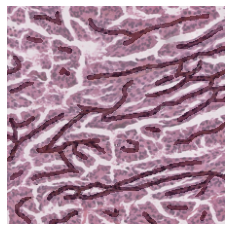

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP13.3201.A5.pRCC/6/crop_x0_y3.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


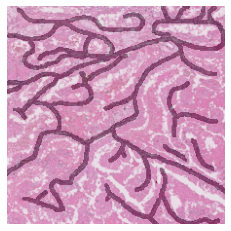

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.8231.A6.pRCC/24_Annotation_2/crop_x2_y0.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


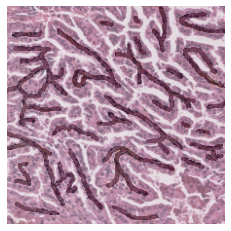

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/ccRCC/HP10.5813.A2/16/crop_x1_y0.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


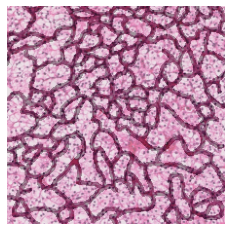

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.10122.B2.pRCC/1/crop_x6_y4.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


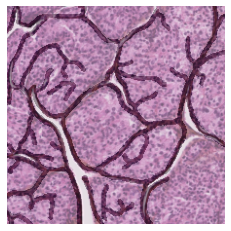

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/ccRCC/HP19.4372.A3.ccRCC/21/crop_x3_y0.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


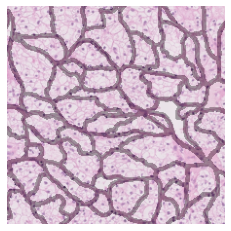

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/ccRCC/HP19.4372.A3.ccRCC/21/crop_x5_y0.png
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


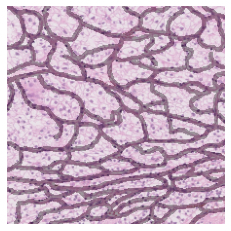

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/ccRCC/HP19.5254.A.ccRCC/26/crop_x1_y5.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


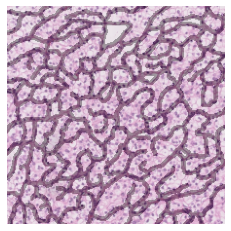

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.4279.R1.pRCC/20_Annotation_6/crop_x1_y6.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


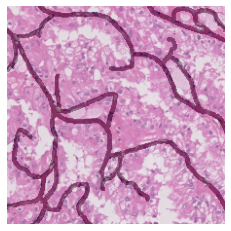

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.8231.A6.pRCC/24_Annotation_3/crop_x2_y3.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


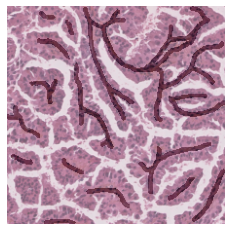

In [10]:
save_path='/content/gdrive/MyDrive/Bioinformatics2/transformations/'

images_to_visualize=[i for i in range(1,10)]

def visualize_image_label_overlay_save(img, label, alpha, save_path):
  '''
  img is a tensor, label is a numpy array
  '''
  plt.imshow(img)
  plt.imshow(label, cmap='Greys', alpha=alpha)
  plt.axis('off')
  plt.savefig(save_path)

def visualize_image_label_overlay(img, label, alpha):
  '''
  img is a tensor, label is a numpy array
  '''
  plt.imshow(img)
  plt.imshow(label, cmap='Greys', alpha=alpha)
  plt.axis('off')
  plt.show()

'''
for i in range(10):
  t_plain=training_dataset_plain[i]
  visualize_image_label_overlay_save(t_plain[0], t_plain[1], 0.3, path_save+'plain')
  t_affine=training_dataset_affine[i]
  visualize_image_label_overlay_save(t_affine[0], t_affine[1], 0.3, path_save+'affine')
  t_elastic=training_dataset_elastic[i]
  visualize_image_label_overlay_save(t_elastic[0], t_elastic[1], 0.3, path_save+'elastic')
  t_pixel=training_dataset_pixel_wise[i]
  visualize_image_label_overlay_save(t_pixel[0], t_pixel[1], 0.3, path_save+'pixelwise')
'''
for i in range(10):
  t_plain=training_dataset_plain[i]
  print(t_plain[1].astype(int))
  visualize_image_label_overlay(t_plain[0], t_plain[1], 0.3)
  

In [12]:
ones_all=0
zeros_all=0
for image,label in training_dataset_plain:
  ones_all+=(label==1).sum()
  zeros_all+=(label==0).sum()
print(ones_all)
print(zeros_all)

/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.8231.A6.pRCC/24_Annotation_2/crop_x4_y2.png
/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP13.3201.A5.pRCC/6/crop_x0_y3.png
/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.8231.A6.pRCC/24_Annotation_2/crop_x2_y0.png
/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/ccRCC/HP10.5813.A2/16/crop_x1_y0.png
/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/pRCC/HP14.10122.B2.pRCC/1/crop_x6_y4.png
/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/ccRCC/HP19.4372.A3.ccRCC/21/crop_x3_y0.png
/content/gdrive/.shortcut-targets-by-id/1mtNVywqwmtCBefeGQrY2c6F6xBQQWq30/vascular_segmentation/Train/ccRCC/HP19.4372.A